In [1]:
import pandas as pd
import numpy as np

from utils import *

/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-19 14:16:15.112966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 14:16:15.133359: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 14:16:15.139630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 14:16:15.155729: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow bina

# 1. Load Data

In [2]:
gene_expression = pd.read_csv('dataset/Genelevel_expectedcounts_matrix.tsv', sep='\t')
gene_info = pd.read_csv('dataset/gene_info.tsv', sep='\t')
meta_data = pd.read_csv('dataset/MetaSheet.csv', encoding='unicode_escape')

### Preprocess Data

In [3]:
# gene expression data
gene_expression.drop(columns=['Unnamed: 0'], inplace=True)
gene_expression = gene_expression.T

# meta data
phase_1_indices = meta_data[meta_data['mgs_level'] == 1]['r_id']
phase_2_indices = meta_data[meta_data['mgs_level'] == 2]['r_id']
phase_3_indices = meta_data[meta_data['mgs_level'] == 3]['r_id']
phase_4_indices = meta_data[meta_data['mgs_level'] == 4]['r_id']

phase_1 = gene_expression.loc[phase_1_indices]
phase_2 = gene_expression.loc[phase_2_indices]
phase_3 = gene_expression.loc[phase_3_indices]
phase_4 = gene_expression.loc[phase_4_indices]

# 2. CS-CORE Method

In [4]:
# hyperparameters
num_genes = 100

### Compute the most expressed genes

In [5]:
top_gene_indices, gene_names = compute_top_genes(gene_expression, num_genes, gene_info)

### Compute the most varying genes among different phases (F-test)

In [5]:
f_test_res = f_test_gene_variances(phase_1, phase_4)

f_test_res.sort_values(by='f_statistic', ascending=False, inplace=True)
# drop the inf values and the NaN values
f_test_res = f_test_res.replace([np.inf, -np.inf], np.nan).dropna()

In [6]:
top_gene_indices = f_test_res[:num_genes].index
gene_names = gene_info.loc[top_gene_indices]['external_gene_name']

### CSCORE over the Whole Dataset

In [7]:
general_results = calc_CSCORE(gene_expression, num_genes, gene_info, top_gene_indices=top_gene_indices)

IRLS converged after 4 iterations.
13 among 100 genes have negative variance estimates. Their co-expressions with other genes were set to 0.
0.2000% co-expression estimates were greater than 1 and were set to 1.
0.0000% co-expression estimates were greater than 1 and were set to 1.


/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/CSCORE/CSCORE_IRLS.py:102: RuntimeWarning: invalid value encountered in sqrt
  test_stat = num / np.sqrt(deno)


### Ablation Study for MGS_level

In [8]:
phase_1_results = calc_CSCORE(phase_1, num_genes, gene_info, top_gene_indices)
phase_2_results = calc_CSCORE(phase_2, num_genes, gene_info, top_gene_indices)
phase_3_results = calc_CSCORE(phase_3, num_genes, gene_info, top_gene_indices)
phase_4_results = calc_CSCORE(phase_4, num_genes, gene_info, top_gene_indices)

IRLS converged after 3 iterations.
12 among 100 genes have negative variance estimates. Their co-expressions with other genes were set to 0.
1.2600% co-expression estimates were greater than 1 and were set to 1.
0.0000% co-expression estimates were greater than 1 and were set to 1.
IRLS converged after 4 iterations.
21 among 100 genes have negative variance estimates. Their co-expressions with other genes were set to 0.
1.7200% co-expression estimates were greater than 1 and were set to 1.
0.3000% co-expression estimates were greater than 1 and were set to 1.
IRLS converged after 4 iterations.
23 among 100 genes have negative variance estimates. Their co-expressions with other genes were set to 0.
1.1400% co-expression estimates were greater than 1 and were set to 1.
0.2200% co-expression estimates were greater than 1 and were set to 1.


/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/CSCORE/CSCORE_IRLS.py:102: RuntimeWarning: invalid value encountered in sqrt
  test_stat = num / np.sqrt(deno)
/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/CSCORE/CSCORE_IRLS.py:57: RuntimeWarning: invalid value encountered in divide
  theta = np.power(mu, 2) / sigma2
/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/CSCORE/CSCORE_IRLS.py:74: RuntimeWarning: invalid value encountered in divide
  theta = np.power(mu, 2) / sigma2
/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/CSCORE/CSCORE_IRLS.py:98: RuntimeWarning: invalid value encountered in divide
  X_weighted = X_centered / Sigma
/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/CSCORE/CSCORE_IRLS.py:100: RuntimeWarning: divide by zero encountered in divide
  seq_depth_sq_weighted = np.einsum("i,ij->ij", seq_depth_sq, 1 / Sigma)
/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/CSCORE/CSCORE_IRLS.py:101: RuntimeWarning: i

IRLS converged after 3 iterations.
47 among 100 genes have negative variance estimates. Their co-expressions with other genes were set to 0.
0.9000% co-expression estimates were greater than 1 and were set to 1.
0.2200% co-expression estimates were greater than 1 and were set to 1.


/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/CSCORE/CSCORE_IRLS.py:102: RuntimeWarning: invalid value encountered in sqrt
  test_stat = num / np.sqrt(deno)


In [8]:
# save results
np.save('results/co_expression/general_results.npy', general_results[0])

np.save('results/co_expression/phase_1_results.npy', phase_1_results[0])
np.save('results/co_expression/phase_2_results.npy', phase_2_results[0])
np.save('results/co_expression/phase_3_results.npy', phase_3_results[0])
np.save('results/co_expression/phase_4_results.npy', phase_4_results[0])

/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


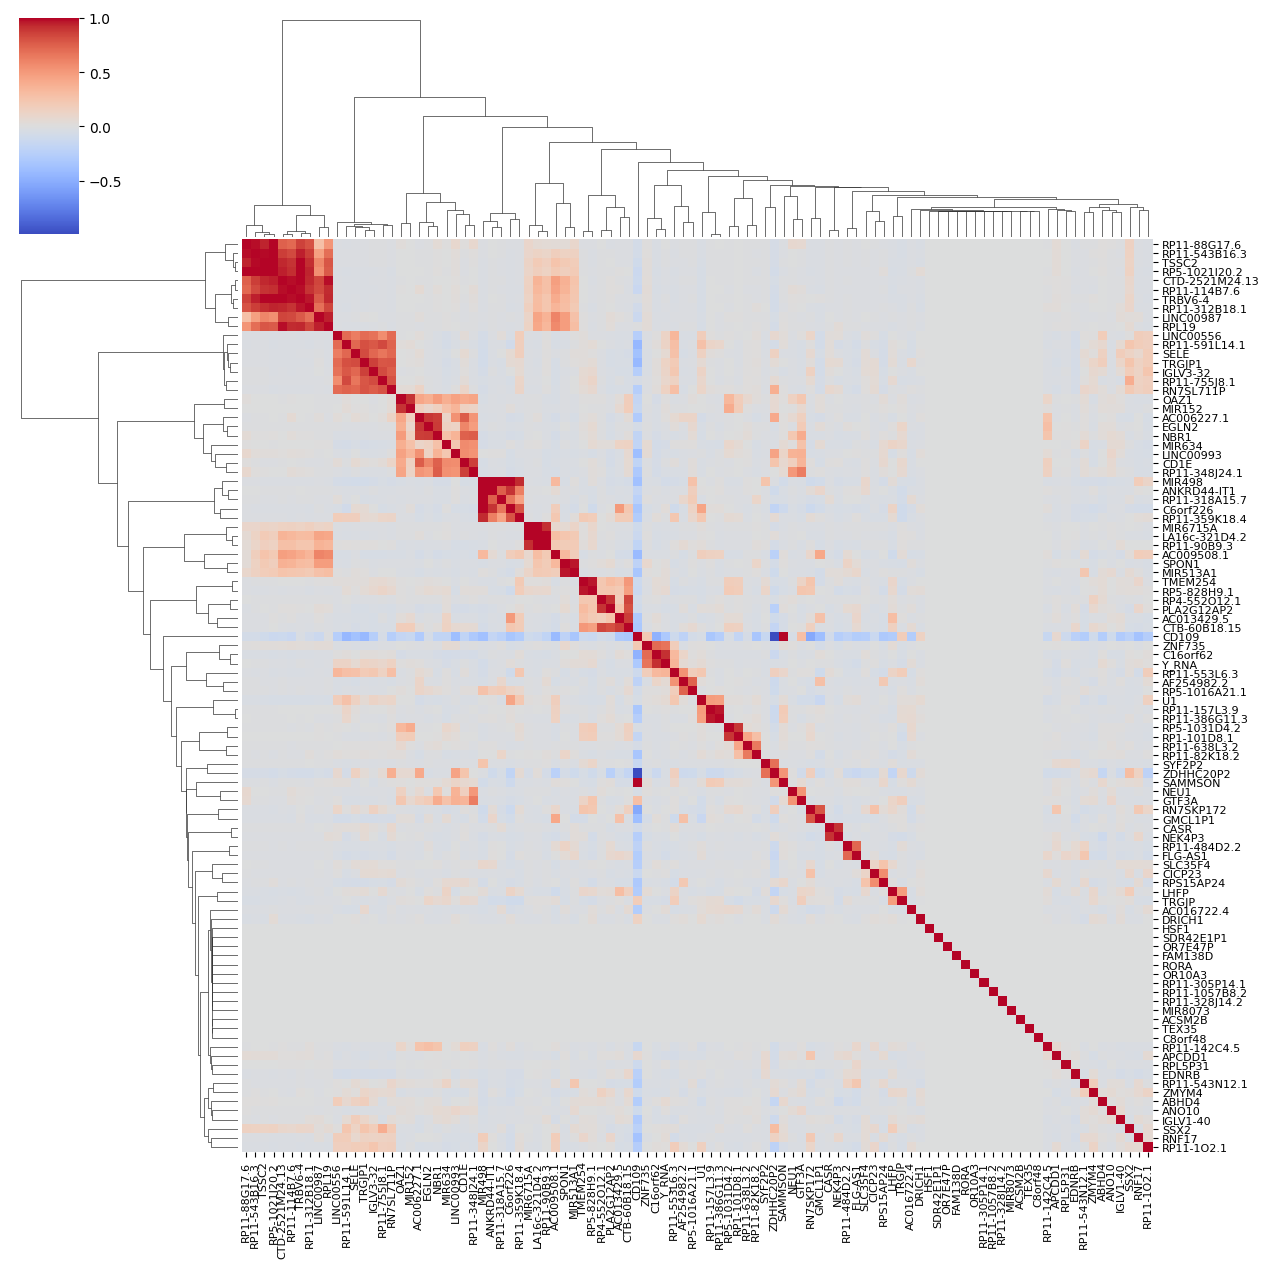

In [9]:
plot_clustermap(general_results[0], gene_names)

# 3. Clustering

In [10]:
# reset index
gene_names = gene_names.reset_index(drop=True)

### Generate Graph using Networkx

In [11]:
general_clustering = calculate_coexpression_graph(general_results[0], gene_names, threshold=0.2)

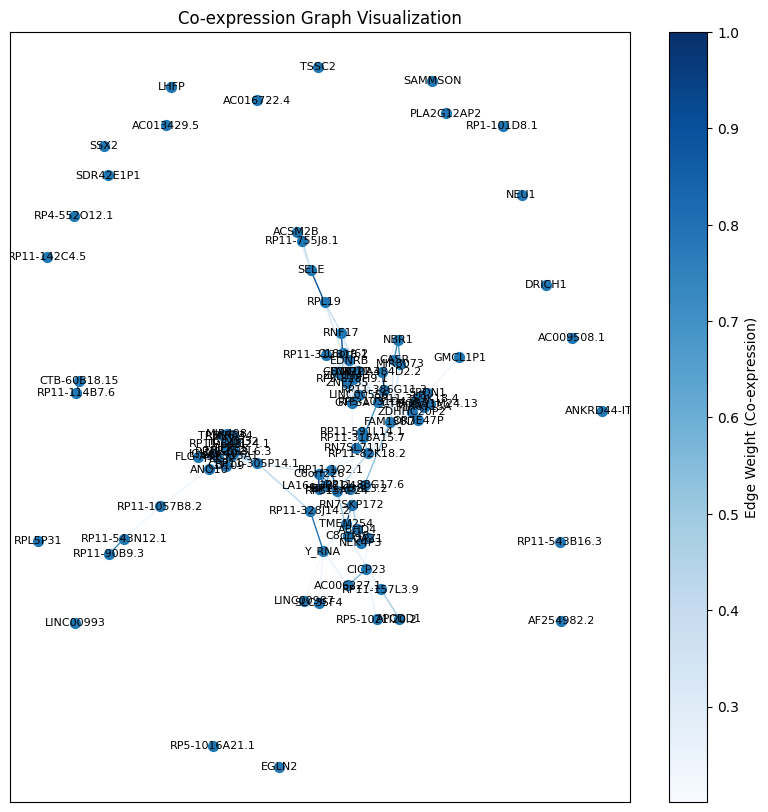

In [26]:
visualize_coexpression_graph(general_clustering)

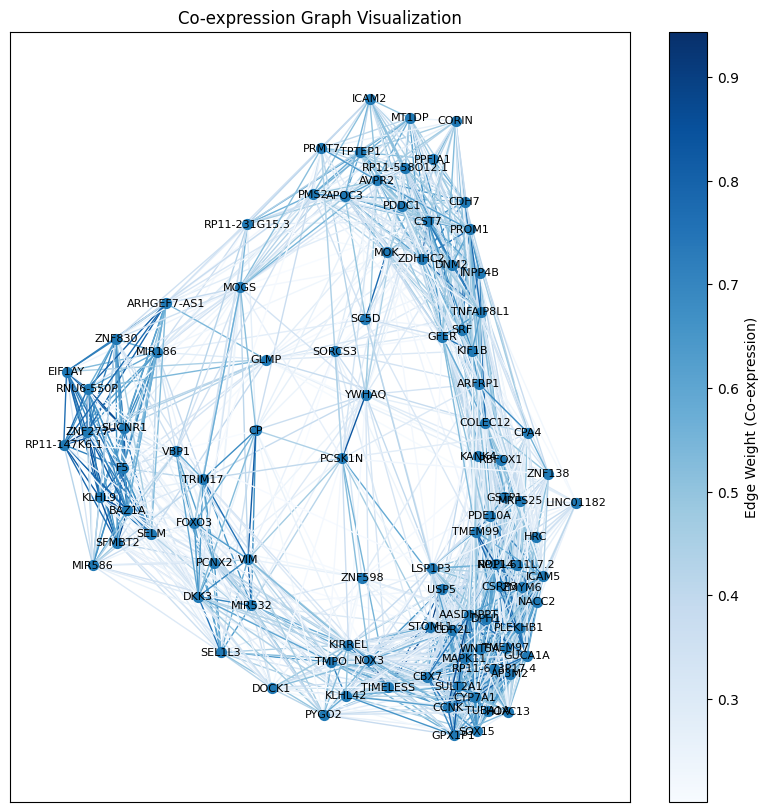

In [26]:
# handle outliers
general_clustering.remove_node('LINC00659')
visualize_coexpression_graph(general_clustering)

### Generate Gene Embeddings from Graph

In [12]:
# hyperparameters
dimensions = 32
n_clusters = 4
p = 1
q = 1

In [13]:
general_embedding = graph_to_node2vec_embeddings(general_clustering, dimensions=dimensions, p=p, q=q)

Computing transition probabilities: 100%|██████████| 100/100 [00:00<00:00, 5213.88it/s]


Generating walks (CPU: 3): 100%|██████████| 50/50 [00:00<00:00, 379.08it/s]


/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


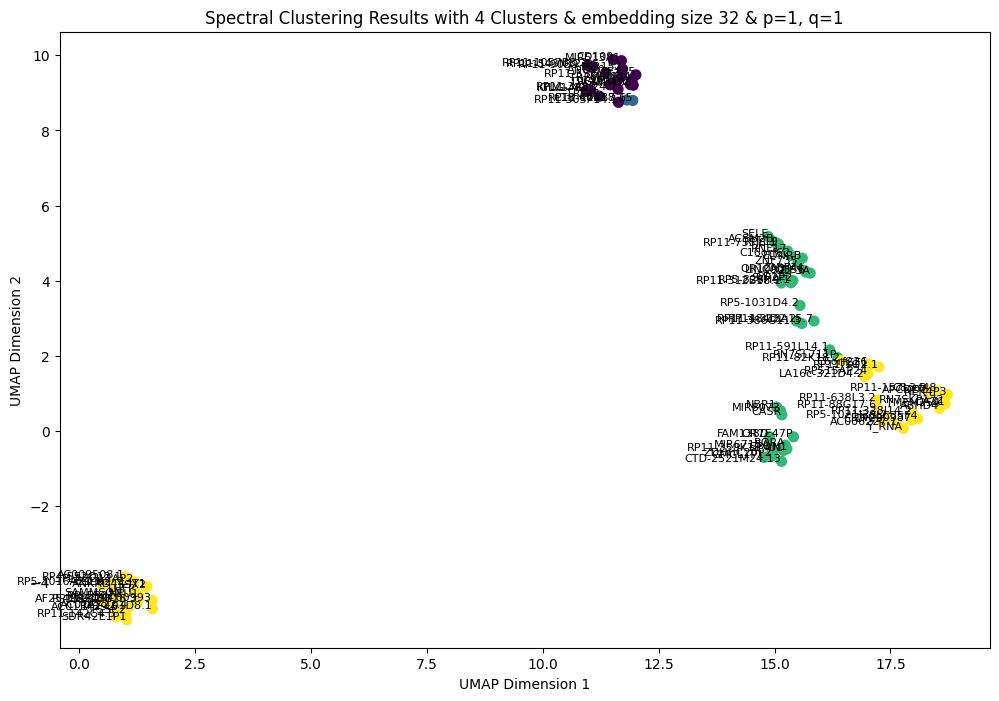

In [17]:
labels = plot_dendrogram_with_embeddings(
    general_embedding, gene_names.squeeze().tolist(), 
    dimensions, n_clusters=n_clusters, p=p, q=q
)

### Ablation Study for MGS_level

In [14]:
phase_1_clustering = calculate_coexpression_graph(phase_1_results[0], gene_names, threshold=0.2)
phase_2_clustering = calculate_coexpression_graph(phase_2_results[0], gene_names, threshold=0.2)
phase_3_clustering = calculate_coexpression_graph(phase_3_results[0], gene_names, threshold=0.2)
phase_4_clustering = calculate_coexpression_graph(phase_4_results[0], gene_names, threshold=0.2)

In [15]:
phase_1_embedding = graph_to_node2vec_embeddings(phase_1_clustering, dimensions=dimensions, p=p, q=q)
phase_2_embedding = graph_to_node2vec_embeddings(phase_2_clustering, dimensions=dimensions, p=p, q=q)
phase_3_embedding = graph_to_node2vec_embeddings(phase_3_clustering, dimensions=dimensions, p=p, q=q)
phase_4_embedding = graph_to_node2vec_embeddings(phase_4_clustering, dimensions=dimensions, p=p, q=q)

Generating walks (CPU: 4):  72%|███████▏  | 36/50 [00:00<00:00, 352.49it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 455.57it/s]


/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


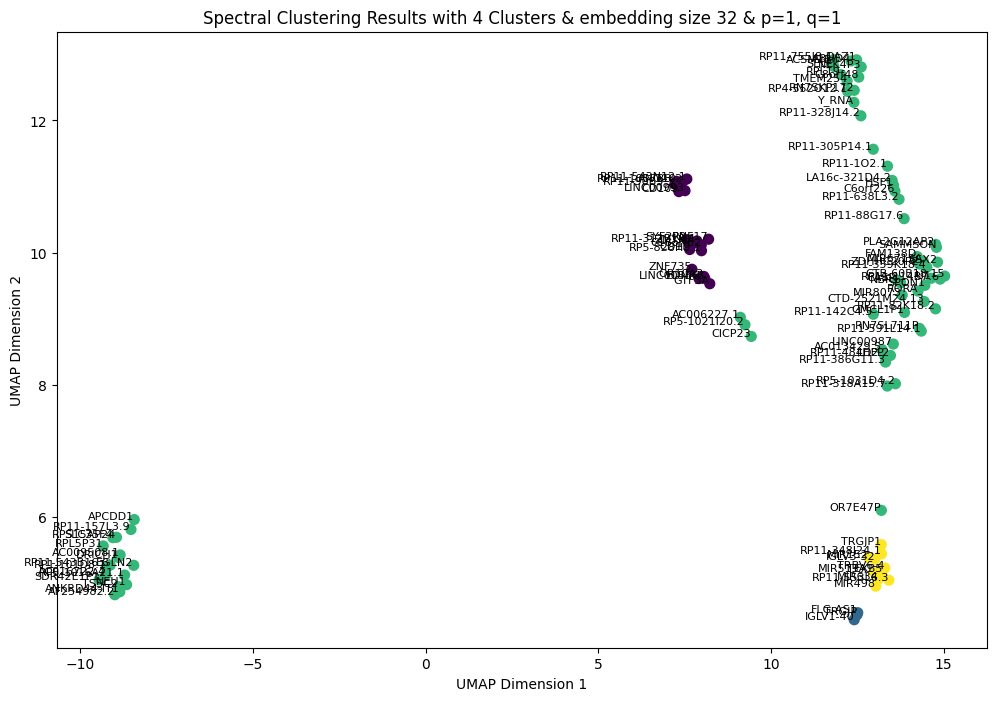

/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


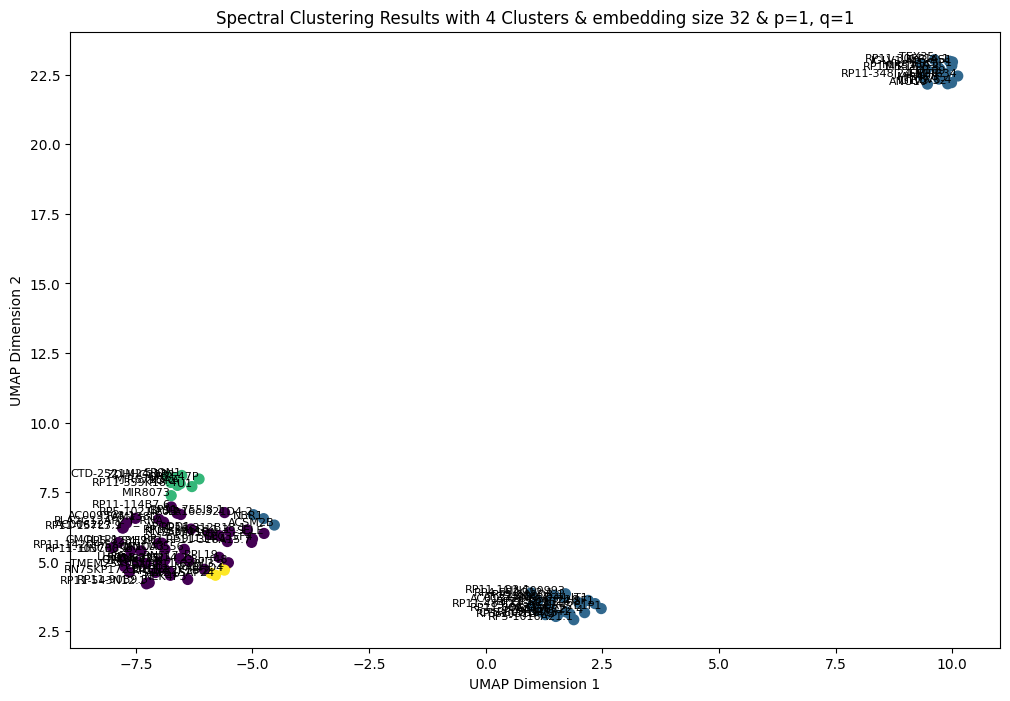

/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


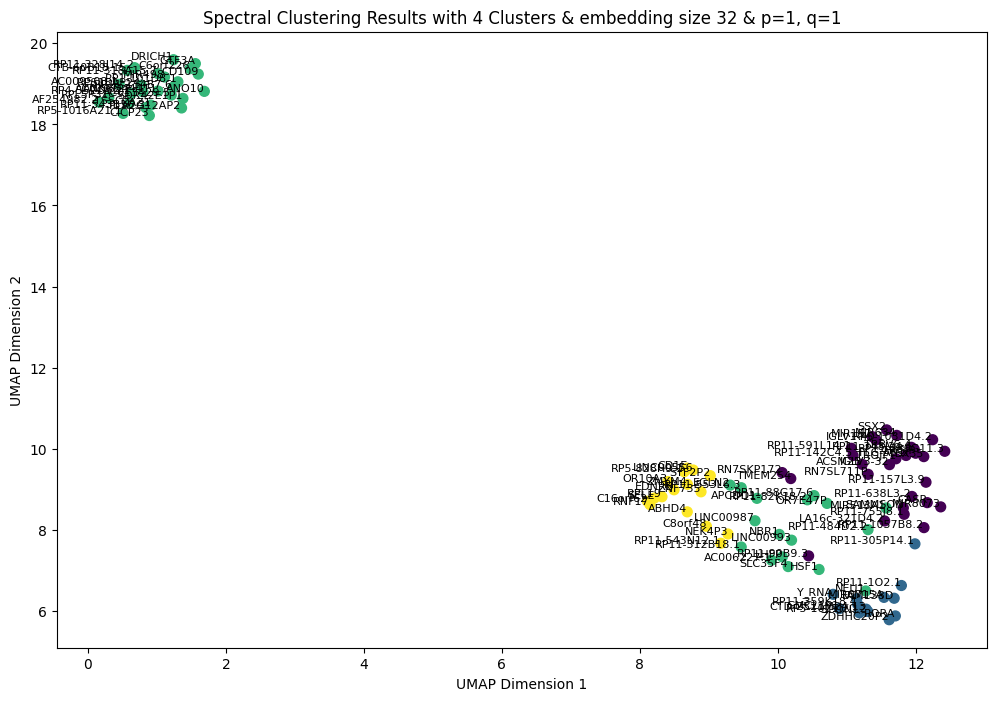

/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


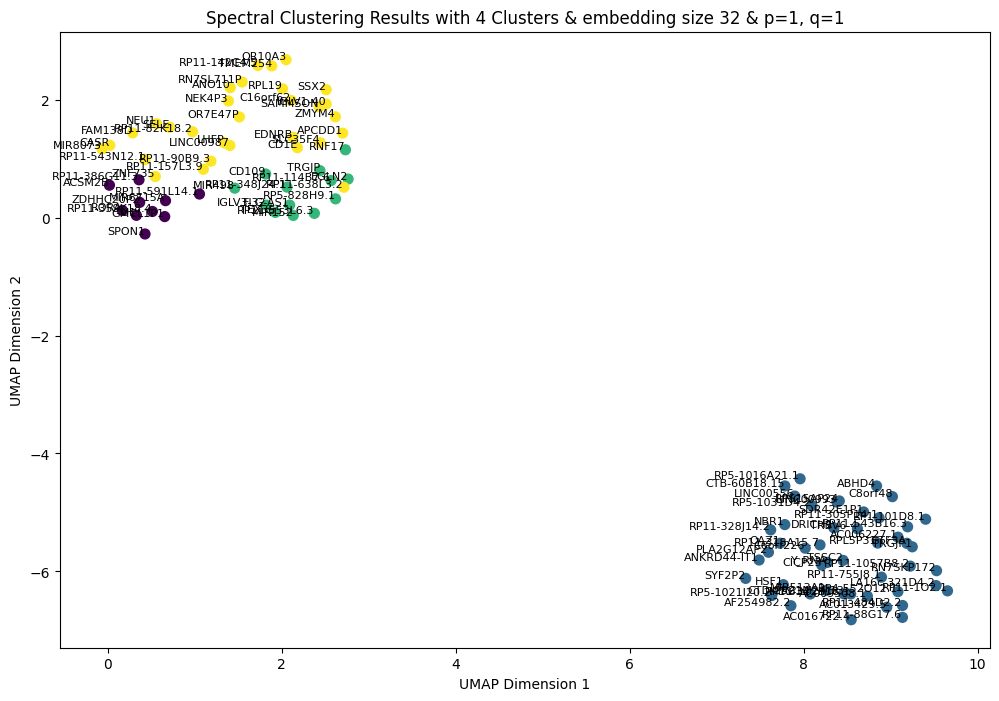

In [16]:
phase_1_labels = plot_dendrogram_with_embeddings(phase_1_embedding, gene_names.squeeze().tolist(), dimensions, n_clusters=n_clusters, p=p, q=q)
phase_2_labels = plot_dendrogram_with_embeddings(phase_2_embedding, gene_names.squeeze().tolist(), dimensions, n_clusters=n_clusters, p=p, q=q)
phase_3_labels = plot_dendrogram_with_embeddings(phase_3_embedding, gene_names.squeeze().tolist(), dimensions, n_clusters=n_clusters, p=p, q=q)
phase_4_labels = plot_dendrogram_with_embeddings(phase_4_embedding, gene_names.squeeze().tolist(), dimensions, n_clusters=n_clusters, p=p, q=q)

In [18]:
# analyze clusters from different phases
cluster_labels = pd.concat([
    pd.DataFrame(gene_names), 
    pd.DataFrame(labels),
    pd.DataFrame(phase_1_labels),
    pd.DataFrame(phase_2_labels),
    pd.DataFrame(phase_3_labels),
    pd.DataFrame(phase_4_labels)
], axis=1)
cluster_labels.columns = ['gene', 'general', 'phase_1', 'phase_2', 'phase_3', 'phase_4']

cluster_labels.to_csv('results/embedding_cluster_labels_F_test.csv', index=False)

In [30]:
cluster_labels

,gene,general,phase_1,phase_2,phase_3,phase_4
0,SUCNR1,2,3,2,3,3
1,F5,2,3,2,3,3
2,MIR186,2,3,2,3,3
3,ZMYM6,0,0,0,0,0
4,SEL1L3,1,2,1,1,1
...,...,...,...,...,...,...
95,CCNK,0,0,0,0,0
96,ICAM5,0,0,0,0,0
97,ZNF138,0,0,0,0,0
98,TRIM17,1,2,1,1,1
